In [1]:
import os
import itertools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import Legend

# AutoML-1 Online results

In [2]:
online_file_to_label = {
  '_lr_online.txt': 'LR',
  '_fm_online.txt': 'FM',
  '_wideNdeep_online.txt': 'Wide&Deep',
  '_deepfm_online.txt': 'DeepFM',
  '_pnn_online.txt': 'PNN',
  '_ipnn_online.txt': 'IPNN',
  '_opnn_online.txt': 'OPNN',
  '_gbdt_online.txt': 'GBDT',
  '_d1_online.txt': 'DeepGBM(D1)',
  '_gbdt2nn_online.txt': 'DeepGBM(D2)',
  '_deepgbm_online.txt': 'DeepGBM',
  '_deepgbm_offline.txt': 'DeepGBM(Off)',
}

def map_online_file_to_label(file):
  for file_suffix, label in online_file_to_label.items():
    if file.endswith(file_suffix):
      return label
  raise ValueError(f"Nothing matches with {file}.")

In [3]:
def filter_results_for(lines, prefix, suffix):
  results = []
  for line in lines:
    if not (line.startswith(prefix) and line.endswith(suffix)):
      continue
    if prefix:
      line = line[len(prefix):]
    if suffix:
      line = line[:-len(suffix)]
    metrics_str = [metric.strip() for metric in line.split(',')]
    metrics = [float(metric_str) for metric_str in metrics_str]
    auc = metrics[-1]
    results.append(auc)
  return results

In [4]:
def get_label_to_results_online(results_dir, online_experiment_files):
  label_to_results = {}
  for experiment_file in online_experiment_files:
    label = map_online_file_to_label(experiment_file)
    path = os.path.join(results_dir, experiment_file)
    with open(path, 'r') as f:
      lines = f.readlines()
    lines = [line.strip() for line in lines]
    if label == 'GBDT':
      results = filter_results_for(lines, '(', ')')
    elif label == 'DeepGBM(Off)':
      results1 = filter_results_for(lines, 'Final Best Metric: ', '')
      assert len(results1) == 10
      results2 = filter_results_for(lines, 'Final metrics: (', ')')
      assert len(results2) == 20
      results = results2
      for i, result in enumerate(results1):
        if i % 2 != 0:
          results[4 * (i // 2)] = result
    else:
      results = filter_results_for(lines, 'Final Best Metric: ', '')

    if label in ['DeepGBM(D2)', 'DeepGBM']:
      # Drop every 1st and every 5 result for models with GBDT2NN, since it outputs the result for GBDT too.
      results = [result for i, result in enumerate(results) if i % 5 != 0]

    assert len(results) == 20
    results = np.array(results)
    results = np.reshape(results, (5, 4))
    label_to_results[label] = results
  return label_to_results

In [5]:
def plot_performance_online(label_to_results, ylim0, ylim1, title):
  fontsize = 16
  fig, ax = plt.subplots(figsize=(16, 12))
  xticks = list(range(1, 5))
  ax.set_xticks(xticks)
  ax.set_xticklabels(['Batch 1', 'Batch 2', 'Batch 3', 'Batch 4'])
  plt.xticks(fontsize=fontsize)
  plt.ylabel('AUC', fontsize=fontsize)
  plt.yticks(fontsize=fontsize)
  plt.ylim((ylim0, ylim1))
  markers = itertools.cycle(('D', 's', '^', 'x', 'P', 'p', 'h', 'X', 'o', 'd', '+', '.'))
  labels = []
  plots = []
  for label, results in label_to_results.items():
    assert results.shape == (5, 4)
    mean = np.mean(results, axis=0)
    print(label)
    print(mean)
    labels.append(label)
    params = {'marker': next(markers)}
    plots.append(ax.plot(xticks, mean, **params)[0])
  plt.title(title, fontsize=fontsize)
  legend_left = ax.legend(plots[0:4], labels[0:4], loc='lower left', prop={'size': fontsize}, frameon=False)
  legend_center = Legend(ax, plots[4:8], labels[4:8], loc='lower center', prop={'size': fontsize}, frameon=False)
  ax.add_artist(legend_center)
  legend_right = Legend(ax, plots[8:12], labels[8:12], loc='lower right', prop={'size': fontsize}, frameon=False)
  ax.add_artist(legend_right)

## Paper results

In [6]:
online_experiment_files = [
  'nipsA_lr_online.txt',
  'nipsA_fm_online.txt',
  'nipsA_wideNdeep_online.txt',
  'nipsA_deepfm_online.txt',
  'nipsA_pnn_online.txt',
  'nipsA_ipnn_online.txt',
  'nipsA_opnn_online.txt',
  'nipsA_gbdt_online.txt',
  'nipsA_d1_online.txt',
  'nipsA_gbdt2nn_online.txt',
  'nipsA_deepgbm_online.txt',
  'nipsA_deepgbm_offline.txt'
]
label_to_results = get_label_to_results_online('results/nipsA_online', online_experiment_files)

LR
[0.70001032 0.67976256 0.68211298 0.68497794]
FM
[0.69806262 0.67975395 0.6854817  0.68715046]
Wide&Deep
[0.70683883 0.70111035 0.70818179 0.71280048]
DeepFM
[0.70584834 0.69819002 0.7072641  0.71070621]
PNN
[0.69884049 0.70032199 0.71014046 0.71689041]
IPNN
[0.70174336 0.70420572 0.71132933 0.7188468 ]
OPNN
[0.69948817 0.69873512 0.70706268 0.71460084]
GBDT
[0.72201301 0.71925145 0.71694445 0.71327032]
DeepGBM(D1)
[0.72255628 0.72532905 0.72607789 0.72634499]
DeepGBM(D2)
[0.72663254 0.73165053 0.73192289 0.73023061]
DeepGBM
[0.725328   0.73200875 0.73199455 0.73198054]
DeepGBM(Off)
[0.725328   0.71115531 0.67601966 0.6308038 ]


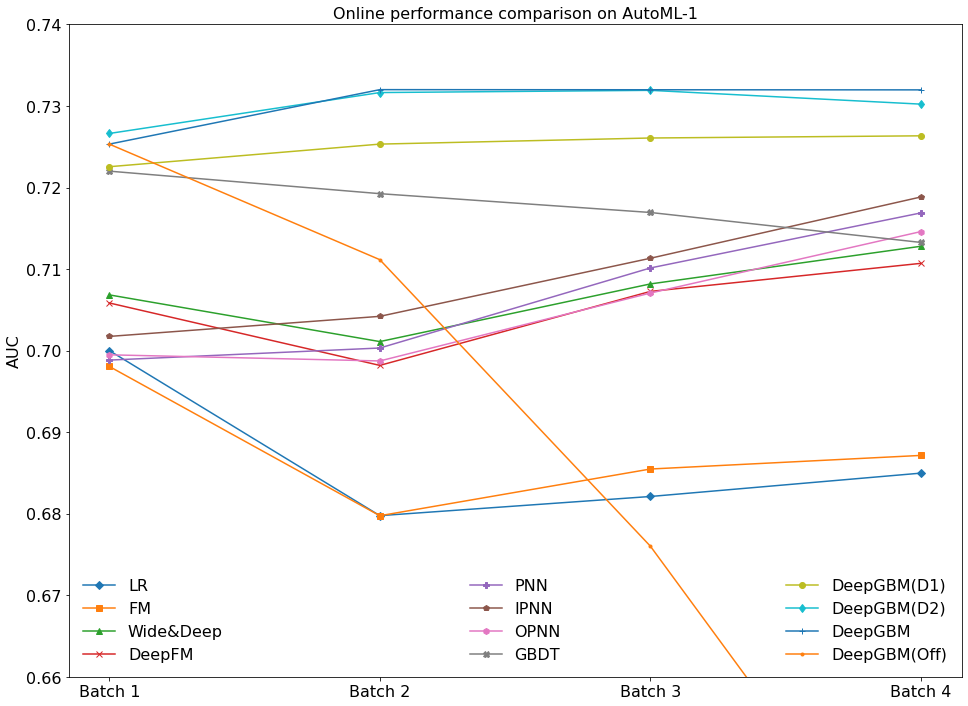

In [7]:
plot_performance_online(
  label_to_results,
  0.66,
  0.74,
  'Online performance comparison on AutoML-1')

## Optimized tree splits

In [8]:
online_experiment_files = [
  'nipsA_lr_online.txt',
  'nipsA_fm_online.txt',
  'nipsA_wideNdeep_online.txt',
  'nipsA_deepfm_online.txt',
  'nipsA_pnn_online.txt',
#   'nipsA_ipnn_online.txt',
#   'nipsA_opnn_online.txt',
  'nipsA_gbdt_online.txt',
  'nipsA_d1_online.txt',
  'nipsA_gbdt2nn_online.txt',
  'nipsA_deepgbm_online.txt',
  'nipsA_deepgbm_offline.txt'
]
label_to_results = get_label_to_results_online('results/optimized_nipsA_online', online_experiment_files)

LR
[0.70001032 0.67976256 0.68211298 0.68497794]
FM
[0.69806262 0.67975395 0.6854817  0.68715046]
Wide&Deep
[0.70683883 0.70111035 0.70818179 0.71280048]
DeepFM
[0.70584834 0.69819002 0.7072641  0.71070621]
PNN
[0.69884049 0.70032199 0.71014046 0.71689041]
GBDT
[0.72201301 0.71925145 0.71694445 0.71327032]
DeepGBM(D1)
[0.72255628 0.72532905 0.72607789 0.72634499]
DeepGBM(D2)
[0.72661078 0.73083001 0.73211727 0.7306986 ]
DeepGBM
[0.72441194 0.73084259 0.73151829 0.73134928]
DeepGBM(Off)
[0.72506649 0.71069057 0.67508286 0.6303211 ]


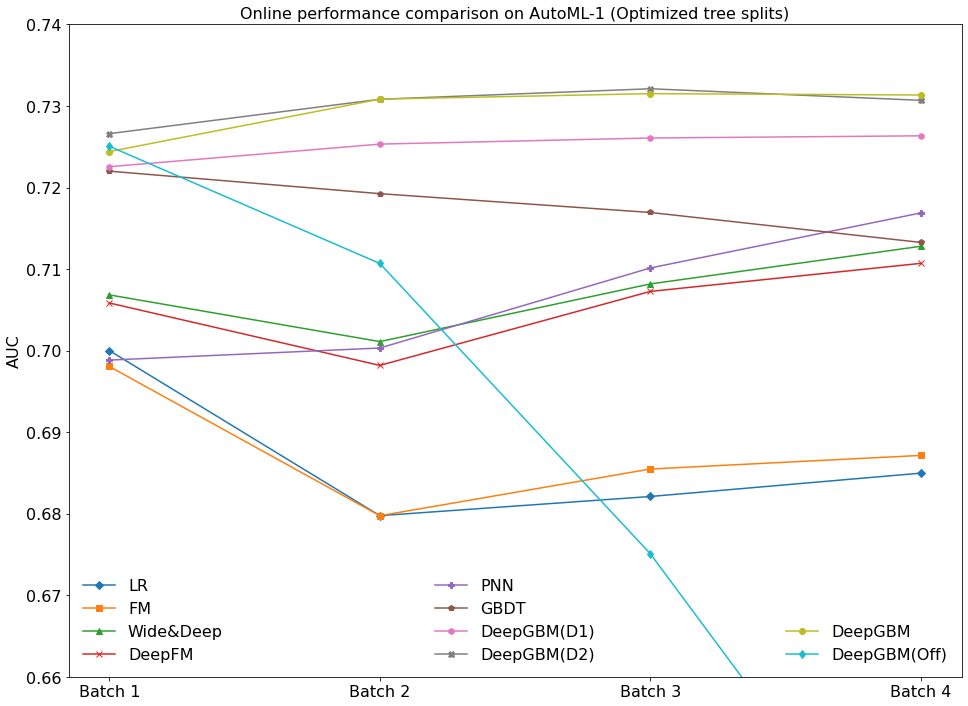

In [9]:
plot_performance_online(
  label_to_results,
  0.66,
  0.74,
  'Online performance comparison on AutoML-1 (Optimized tree splits)')

# AutoML-1 Offline results

In [10]:
offline_file_to_label = {
  '_lr_offline.txt': 'LR',
  '_fm_offline.txt': 'FM',
  '_wideNdeep_offline.txt': 'Wide&Deep',
  '_deepfm_offline.txt': 'DeepFM',
  '_pnn_offline.txt': 'PNN',
  '_gbdt_offline.txt': 'GBDT',
  '_d1_offline.txt': 'DeepGBM(D1)',
  '_gbdt2nn_offline.txt': 'DeepGBM(D2)',
  '_deepgbm_offline.txt': 'DeepGBM',
}

def map_offline_file_to_label(file):
  for file_suffix, label in offline_file_to_label.items():
    if file.endswith(file_suffix):
      return label
  raise ValueError(f"Nothing matches with {file}.")

In [11]:
import collections

EpochAuc = collections.namedtuple('EpochAuc', ['epoch', 'auc'])

def load_results_from_path(experiment_path):
  with open(experiment_path, 'r') as f:
    lines = f.readlines()
  lines = [line.strip() for line in lines]
  results = []
  for i, line in enumerate(lines):
    if line == 'Evaluate Result:':
      if not results:
        results.append([])
      nline = lines[i + 1]
      handle = 'Testing AUC: '
      handle_index = nline.find(handle)
      epoch = int(nline[6:9])
      auc = float(nline[handle_index+len(handle):handle_index+len(handle)+8])
      if results[-1] and results[-1][-1].epoch == epoch:
        # Testing during the same epoch => replace with the new score
        results[-1][-1] = EpochAuc(epoch, auc)
      else:
        if results[-1] and results[-1][-1].epoch > epoch:
          results.append([])
        results[-1].append(EpochAuc(epoch, auc))
        
  if not results:
    # GBDT training
    for line in lines:
      if line and line[0] == '(' and line[-1] == ')':
        epoch = 0
        metrics_str = [metric.strip() for metric in line[1:-1].split(',')]
        metrics = [float(metric_str) for metric_str in metrics_str]
        auc = metrics[-1]
        results.append([EpochAuc(-1, auc)])

  assert results
  return results

In [12]:
def plot_performance_offline(offline_experiment_files, results_dir, ylim0, ylim1, title):
  fontsize = 16
  fig, ax = plt.subplots(figsize=(16, 12))
  xticks = list(range(20))
  ax.set_xticks(xticks)
  plt.xticks(fontsize=fontsize)
  plt.ylabel('AUC', fontsize=fontsize)
  plt.yticks(fontsize=fontsize)
  plt.ylim((ylim0, ylim1))

  markers = itertools.cycle(('D', 's', '^', 'x', 'P', 'p', 'h', 'X', 'o'))
  labels = []
  plots = []
  for experiment_file in offline_experiment_files:
    label = map_offline_file_to_label(experiment_file)
    experiment_path = os.path.join(results_dir, experiment_file)
    results = load_results_from_path(experiment_path)
    epoch_to_aucs = collections.defaultdict(list)
    for run in results:
      for epoch, auc in run:
        epoch_to_aucs[epoch].append(auc)
    epoch_to_mean = {}
    for epoch, aucs in epoch_to_aucs.items():
      epoch_to_mean[epoch] = np.mean(aucs)
    epoch_means = list(sorted(epoch_to_mean.items()))
    epochs = [em[0] for em in epoch_means]
    means = [em[1] for em in epoch_means]
    # Handling the models without epochs
    if epochs == [-1]:
      epochs = xticks
      means = means * len(xticks)

    labels.append(label)
    params = {}
    params['marker'] = next(markers)
    plots.append(ax.plot(epochs, means, **params)[0])
    print(label)
    print(means)
    print('Best:', np.max(means))

  plt.title(title, fontsize=fontsize)
  legend = ax.legend(plots, labels, prop={'size': fontsize}, loc='lower left', frameon=False)

## Paper results

In [13]:
offline_experiment_files = [
  'nipsA_lr_offline.txt',
  'nipsA_fm_offline.txt',
  'nipsA_wideNdeep_offline.txt',
  'nipsA_deepfm_offline.txt',
  'nipsA_pnn_offline.txt',
  'nipsA_gbdt_offline.txt',
  'nipsA_d1_offline.txt',
  'nipsA_gbdt2nn_offline.txt',
  'nipsA_deepgbm_offline.txt',
]

LR
[0.7276212, 0.7232664, 0.7160946, 0.707801, 0.7024001999999999, 0.6970916, 0.6925756, 0.6879706, 0.6856253999999999, 0.6829972, 0.6806364, 0.6792602000000001, 0.6770974, 0.6757332, 0.6743736, 0.6738942, 0.6723334, 0.6715519999999999, 0.6701189999999999, 0.6705714]
Best: 0.7276212
FM
[0.7308195999999999, 0.7247652, 0.7156170000000001, 0.7075495999999999, 0.7007004, 0.6941422000000002, 0.6899792, 0.6857046, 0.6837808000000001, 0.6821280000000002, 0.680285, 0.6780036, 0.6769368, 0.6742944000000001, 0.6744517999999999, 0.6725407999999999, 0.6722892, 0.6723684000000001, 0.6706945999999999, 0.6701121999999999]
Best: 0.7308195999999999
Wide&Deep
[0.7408816, 0.7380677999999999, 0.7323274000000001, 0.7278222000000001, 0.723442, 0.7191922, 0.7157874, 0.7119668, 0.7113352, 0.7090802, 0.7063656, 0.7059554, 0.704, 0.7029256, 0.7012065999999999, 0.7000746, 0.698959, 0.6970295999999999, 0.6967268, 0.6963348]
Best: 0.7408816
DeepFM
[0.7399647999999999, 0.7368792, 0.729357, 0.722579, 0.716301, 0.710

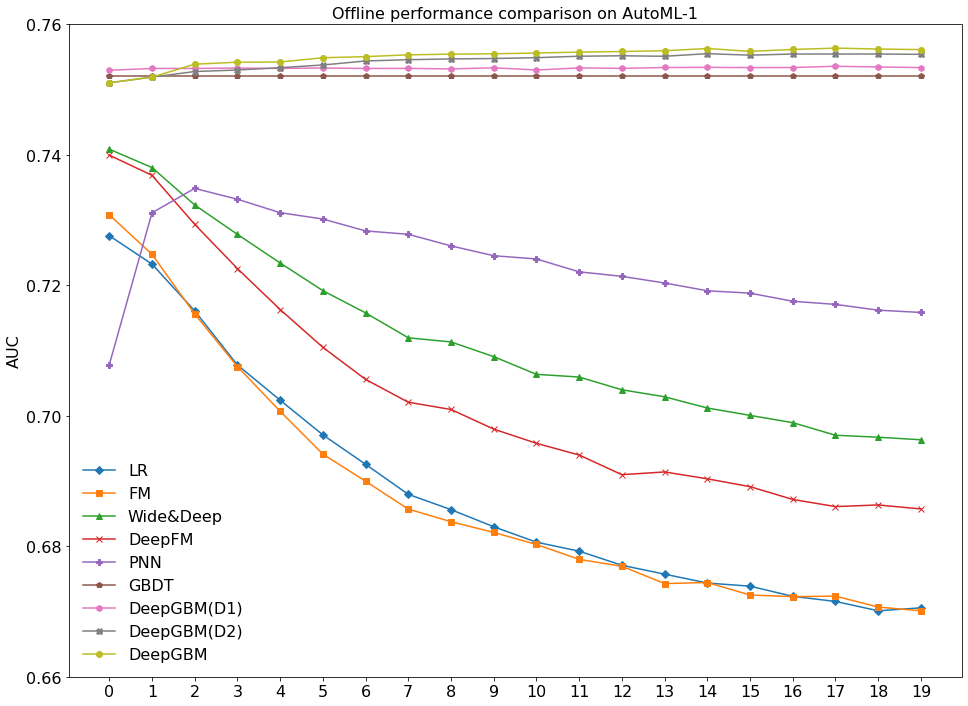

In [14]:
plot_performance_offline(
  offline_experiment_files,
  'results/nipsA_offline',
  0.66,
  0.76,
  'Offline performance comparison on AutoML-1')

## Optimized tree splits

LR
[0.7276212, 0.7232664, 0.7160946, 0.707801, 0.7024001999999999, 0.6970916, 0.6925756, 0.6879706, 0.6856253999999999, 0.6829972, 0.6806364, 0.6792602000000001, 0.6770974, 0.6757332, 0.6743736, 0.6738942, 0.6723334, 0.6715519999999999, 0.6701189999999999, 0.6705714]
Best: 0.7276212
FM
[0.7308195999999999, 0.7247652, 0.7156170000000001, 0.7075495999999999, 0.7007004, 0.6941422000000002, 0.6899792, 0.6857046, 0.6837808000000001, 0.6821280000000002, 0.680285, 0.6780036, 0.6769368, 0.6742944000000001, 0.6744517999999999, 0.6725407999999999, 0.6722892, 0.6723684000000001, 0.6706945999999999, 0.6701121999999999]
Best: 0.7308195999999999
Wide&Deep
[0.7408816, 0.7380677999999999, 0.7323274000000001, 0.7278222000000001, 0.723442, 0.7191922, 0.7157874, 0.7119668, 0.7113352, 0.7090802, 0.7063656, 0.7059554, 0.704, 0.7029256, 0.7012065999999999, 0.7000746, 0.698959, 0.6970295999999999, 0.6967268, 0.6963348]
Best: 0.7408816
DeepFM
[0.7399647999999999, 0.7368792, 0.729357, 0.722579, 0.716301, 0.710

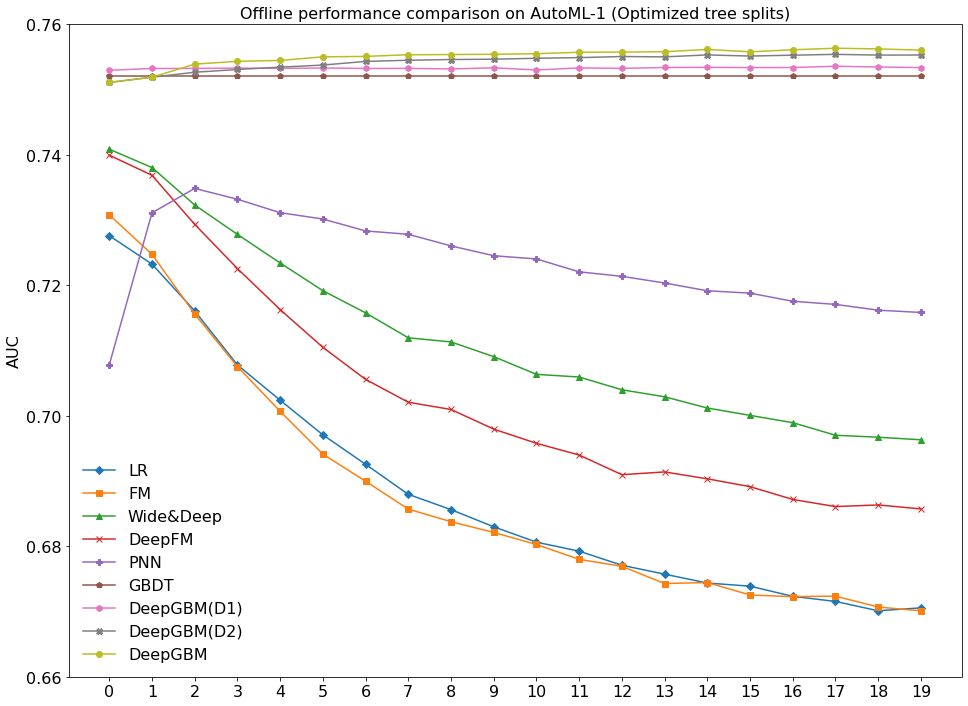

In [15]:
plot_performance_offline(
  offline_experiment_files,
  'results/optimized_nipsA_offline',
  0.66,
  0.76,
  'Offline performance comparison on AutoML-1 (Optimized tree splits)')

# Expedia Online results

## Paper results

In [16]:
online_experiment_files = [
  'expedia_lr_online.txt',
  'expedia_fm_online.txt',
  'expedia_wideNdeep_online.txt',
  'expedia_deepfm_online.txt',
  'expedia_pnn_online.txt',
#   'expedia_ipnn_online.txt',
#   'expedia_opnn_online.txt',
  'expedia_gbdt_online.txt',
  'expedia_d1_online.txt',
  'expedia_gbdt2nn_online.txt',
  'expedia_deepgbm_online.txt',
  'expedia_deepgbm_offline.txt'
]
label_to_results = get_label_to_results_online('results/expedia_online', online_experiment_files)

LR
[0.74281714 0.73789667 0.73801533 0.72730089]
FM
[0.74478389 0.73453845 0.73679545 0.72560899]
Wide&Deep
[0.76099414 0.76592394 0.77017938 0.76367288]
DeepFM
[0.75879144 0.76356786 0.76686377 0.75960929]
PNN
[0.74461884 0.76173773 0.76783507 0.761101  ]
GBDT
[0.8019761  0.80983658 0.81056585 0.80104027]
DeepGBM(D1)
[0.80412654 0.81623143 0.81893919 0.80996043]
DeepGBM(D2)
[0.8055433  0.82349094 0.82414156 0.81394744]
DeepGBM
[0.80581337 0.82323761 0.82392505 0.81341431]
DeepGBM(Off)
[0.80581337 0.79862473 0.79596138 0.78436114]


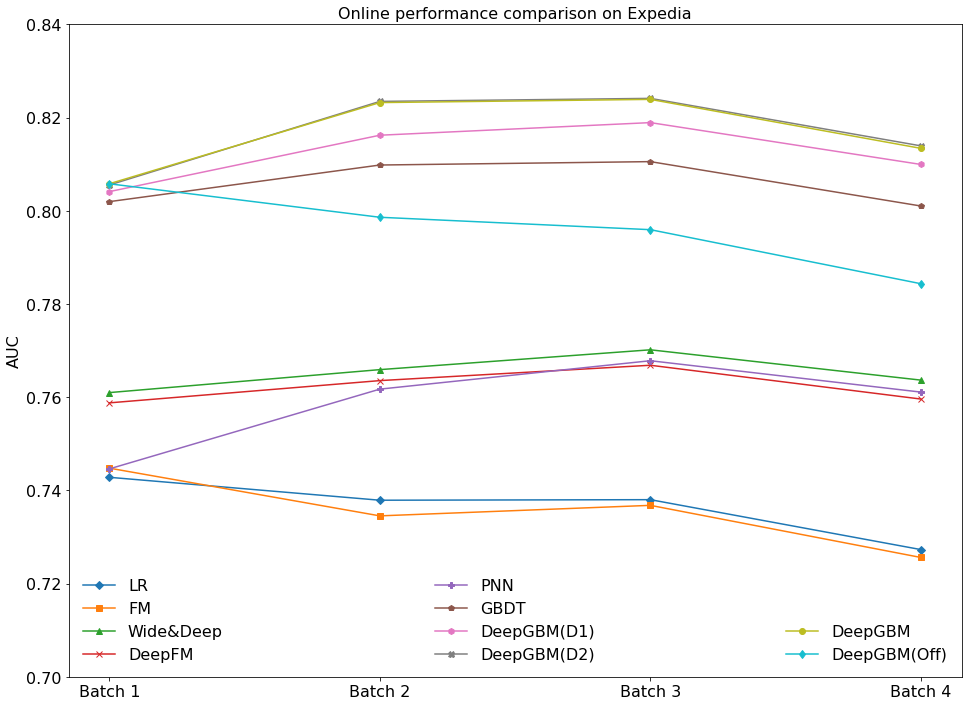

In [17]:
plot_performance_online(
  label_to_results,
  0.70,
  0.84,
  'Online performance comparison on Expedia')

# Expedia Offline results

## Paper results

In [18]:
offline_experiment_files = [
  'expedia_lr_offline.txt',
  'expedia_fm_offline.txt',
  'expedia_wideNdeep_offline.txt',
  'expedia_deepfm_offline.txt',
  'expedia_pnn_offline.txt',
  'expedia_gbdt_offline.txt',
  'expedia_d1_offline.txt',
  'expedia_gbdt2nn_offline.txt',
  'expedia_deepgbm_offline.txt',
]

LR
[0.7567542, 0.7596818, 0.7591901999999999, 0.7589176, 0.7543078, 0.7546588, 0.751845, 0.7493846000000001, 0.7480806000000001, 0.7452012, 0.7441523999999999, 0.7410564, 0.74009, 0.7382296, 0.7374103999999999, 0.7364812000000001, 0.7364483999999999, 0.7347742, 0.7333346000000001, 0.732335]
Best: 0.7596818
FM
[0.7577807999999999, 0.758836, 0.7568849999999999, 0.7553408, 0.7480848000000001, 0.7474888, 0.7446118, 0.7404966, 0.7393668, 0.7345025999999999, 0.7339144000000001, 0.7319942, 0.7309294, 0.729913, 0.7289243999999999, 0.7278596, 0.7279218, 0.7260038, 0.7268116, 0.7268209999999999]
Best: 0.758836
Wide&Deep
[0.7694132, 0.768799, 0.7633654, 0.7608976000000001, 0.7558596, 0.7528282, 0.7486546000000001, 0.7437984, 0.7430324, 0.7401894, 0.7370454000000001, 0.7352821999999999, 0.7340974000000001, 0.7332862, 0.7335024, 0.7330664, 0.7335106, 0.7335838, 0.731085, 0.7313273999999998]
Best: 0.7694132
DeepFM
[0.7677156, 0.7668256, 0.7613, 0.7586489999999999, 0.7524586, 0.7503398, 0.7458904, 0.

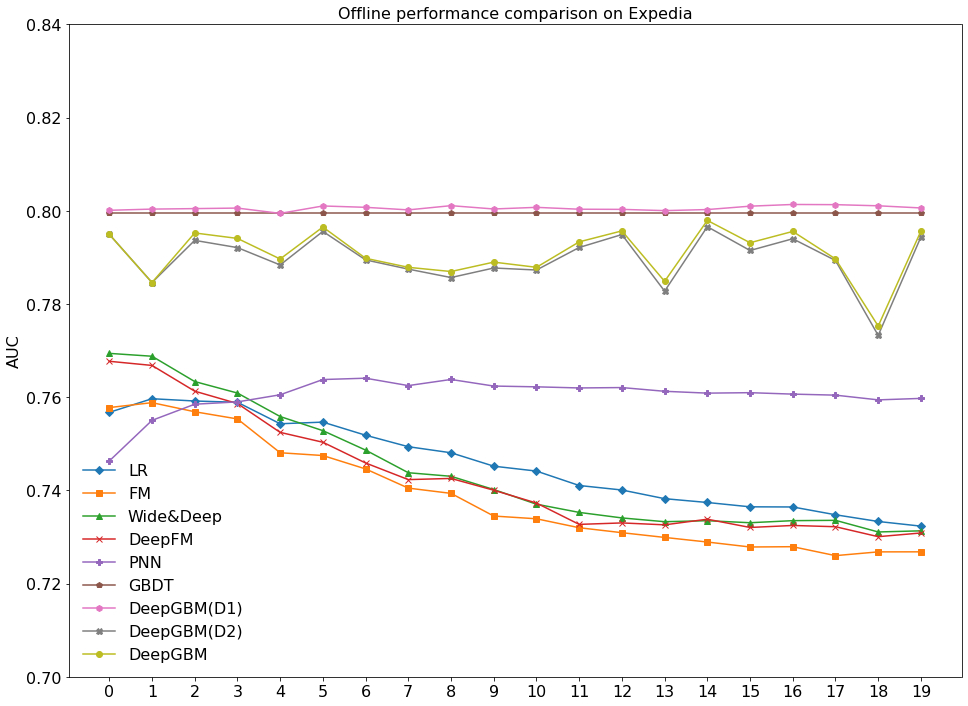

In [19]:
plot_performance_offline(
  offline_experiment_files,
  'results/expedia_offline',
  0.70,
  0.84,
  'Offline performance comparison on Expedia')